--- Data Loaded ---
Total Movies: 4815

--- Similarity Matrix Calculated ---

Skipping full heatmap generation: Matrix is too large. Plotting a 50x50 sample...


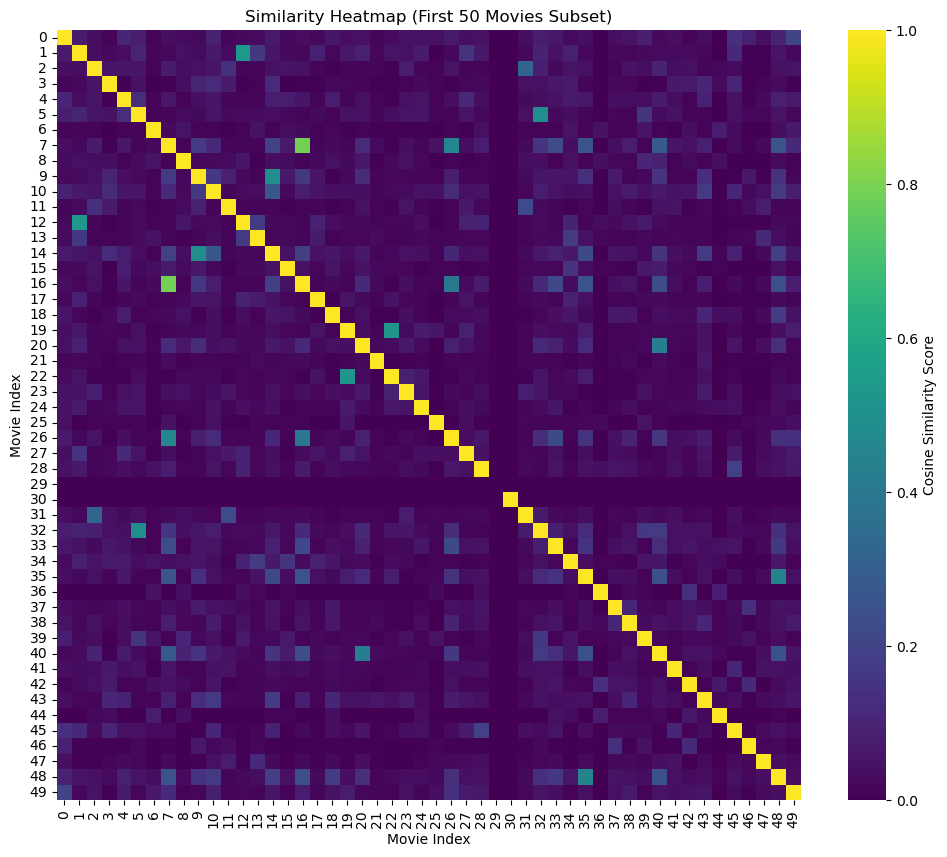


 Enter your favourite movie name :  Avatar


Close match found: Avatar
Internal index of 'Avatar': 0


C:\Users\Muzamil Hussain\AppData\Local\Temp\ipykernel_13264\3574464318.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


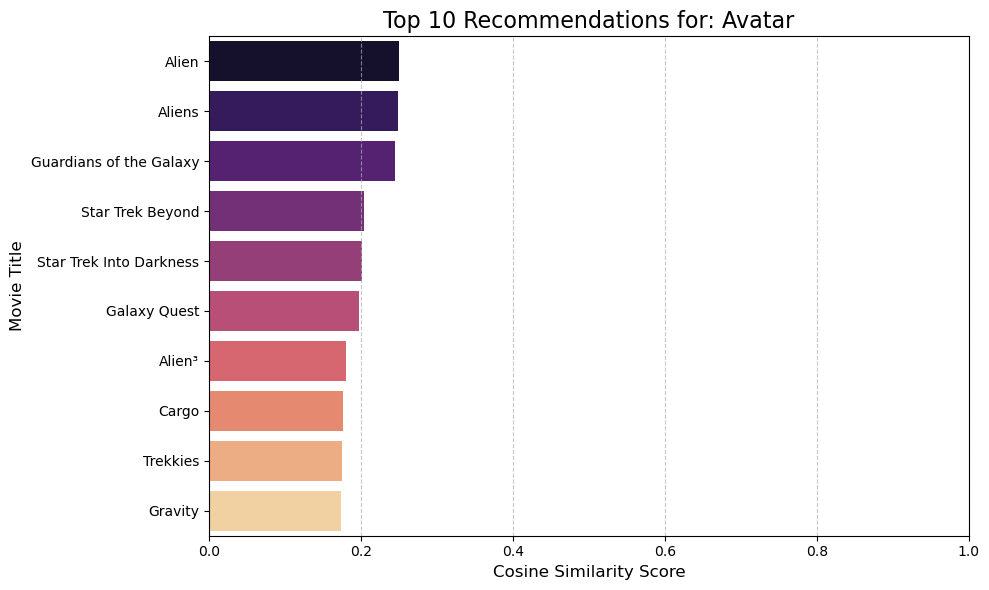


Movies suggested for you (Top 30) : 

1. Alien
2. Aliens
3. Guardians of the Galaxy
4. Star Trek Beyond
5. Star Trek Into Darkness
6. Galaxy Quest
7. Alien³
8. Cargo
9. Trekkies
10. Gravity
11. Moonraker
12. Jason X
13. Pocahontas
14. Space Cowboys
15. The Helix... Loaded
16. Lockout
17. Event Horizon
18. Space Dogs
19. Machete Kills
20. Gettysburg
21. Clash of the Titans
22. Star Wars: Clone Wars: Volume 1
23. The Right Stuff
24. Terminator Salvation
25. The Astronaut's Wife
26. Planet of the Apes
27. Star Trek
28. Wing Commander
29. Sunshine
30. The Terminator


In [120]:
import numpy as np
import pandas as pd
import difflib
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: Set your correct file path here.
FILE_PATH = "C:\\Users\\Muzamil Hussain\\Desktop\\movies.csv"

# --- 0. VISUALIZATION AND HELPER FUNCTIONS ---

def get_scalar_score(item):
    """
    Helper function to safely extract the scalar score from the (index, score) tuple item.
    This handles cases where the score might be wrapped in a single-element list/array.
    """
    score = item[1]
    if isinstance(score, (list, np.ndarray)) and len(score) == 1:
        return score[0]
    return score

def plot_similarity_heatmap(similarity_matrix):
    """
    Generates and displays a heatmap of the entire similarity matrix.
    If the dataset is too large, it plots a 50x50 subset for demonstration.
    """
    if similarity_matrix.shape[0] > 500:
        print("\nSkipping full heatmap generation: Matrix is too large. Plotting a 50x50 sample...")
        # Plot a small 50x50 subset for demonstration
        subset = similarity_matrix[:50, :50]
        title = "Similarity Heatmap (First 50 Movies Subset)"
    else:
        subset = similarity_matrix
        title = "Full Movie Similarity Heatmap"

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        subset,
        annot=False,
        fmt=".2f",
        cmap='viridis',
        cbar_kws={'label': 'Cosine Similarity Score'}
    )
    plt.title(title)
    plt.xlabel("Movie Index")
    plt.ylabel("Movie Index")
    plt.show()
    # 

def plot_recommendation_bar_chart(sorted_movies, movies_data, index_of_the_movie, top_n=10):
    """
    Generates and displays a bar chart of the top N recommended movies and their scores.
    """
    
    recommendations = []
    input_title = movies_data.loc[index_of_the_movie, 'title']

    count = 0
    for movie in sorted_movies:
        index = movie[0]
        score = get_scalar_score(movie) 
        
        # Skip the movie itself
        if index == index_of_the_movie:
            continue
        
        if count < top_n:
            title = movies_data.loc[index, 'title']
            recommendations.append({'title': title, 'score': score})
            count += 1
        else:
            break

    df_recs = pd.DataFrame(recommendations)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='score',
        y='title',
        data=df_recs,
        palette='magma'
    )
    plt.title(f'Top {top_n} Recommendations for: {input_title}', fontsize=16)
    plt.xlabel('Cosine Similarity Score', fontsize=12)
    plt.ylabel('Movie Title', fontsize=12)
    plt.xlim(0, 1.0)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    # 


# --- 1. DATA LOADING AND PREPROCESSING ---

try:
    # Adding low_memory=False to resolve the DtypeWarning
    movies_data = pd.read_csv(FILE_PATH, low_memory=False) 
except FileNotFoundError:
    print(f"ERROR: File not found at {FILE_PATH}")
    sys.exit()

print("--- Data Loaded ---")
print(f"Total Movies: {movies_data.shape[0]}")

# Selecting the relevant features for recommendation
selected_features = ['genres','keywords','tagline','cast','director']

# Replacing the null values (NaN) with an empty string ('')
for feature in selected_features:
    movies_data.loc[:, feature] = movies_data[feature].fillna('').astype(str)

# Combining all the selected features into one large string column
combined_features = movies_data['genres']+' '+movies_data['keywords']+' '+movies_data['tagline']+' '+movies_data['cast']+' '+movies_data['director']

# --- 2. FEATURE VECTORIZATION AND SIMILARITY CALCULATION ---

vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)

# Getting the similarity scores using cosine similarity
similarity = cosine_similarity(feature_vectors)
print("\n--- Similarity Matrix Calculated ---")

# --- PLACEMENT 1: HEATMAP CALL ---
# This visualizes the overall similarity relationships in the dataset.
plot_similarity_heatmap(similarity)

# --- 3. RECOMMENDATION LOGIC ---

# ---- INDEX SETUP ----
movies_data = movies_data.reset_index(drop=True)
movies_data['movie_id'] = movies_data.index
movies_data['title'] = movies_data['title'].astype(str)

# ---- INPUT AND CLOSE MATCH CHECK ----
while True:
    movie_name = input('\n Enter your favourite movie name : ').strip()
    if not movie_name:
        print("Please enter a movie name.")
        continue

    list_of_all_titles = movies_data['title'].tolist()
    find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

    if not find_close_match:
        print("No similar movie found. Please check spelling or try a different name.")
        continue
    else:
        close_match = find_close_match[0]
        print(f"Close match found: {close_match}")
        break

# ---- GET MOVIE ID SAFELY ----
row = movies_data[movies_data.title == close_match]

if not row.empty:
    index_of_the_movie = row['movie_id'].iloc[0]
    print(f"Internal index of '{close_match}': {index_of_the_movie}")

    # ---- SIMILARITY SCORE & FLATTENING ----
    movie_similarity_scores = similarity[index_of_the_movie]
    if isinstance(movie_similarity_scores, np.ndarray) and movie_similarity_scores.ndim > 1:
        movie_similarity_scores = movie_similarity_scores.flatten()

    similarity_score = list(enumerate(movie_similarity_scores))

    # ---- SORT ----
    # Sorting using the robust helper function 
    sorted_similar_movies = sorted(similarity_score, key=get_scalar_score, reverse=True)
    
    # --- PLACEMENT 2: BAR CHART CALL ---
    # This visualizes the similarity scores of the top recommendations for the input movie.
    plot_recommendation_bar_chart(sorted_similar_movies, movies_data, index_of_the_movie, top_n=10)

    # --- 4. DISPLAY TEXT RESULTS ---
    print('\nMovies suggested for you (Top 30) : \n')

    i = 1
    for movie in sorted_similar_movies:
        index = movie[0]
        title_from_index = movies_data.loc[index, 'title']

        # Skip the input movie itself
        if index == index_of_the_movie:
            continue

        if i <= 30:
            print(f"{i}. {title_from_index}")
            i += 1
            
else:
    print(f"FATAL ERROR: Failed to locate movie data for '{close_match}'.")